# Explaining cortical thickness development: Destrieux CT predictors 

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

from os.path import join
from matplotlib import pyplot as plt
import seaborn as sns
from neuromaps import parcellate, images, resampling
from scipy.stats import zscore
from IPython.display import display
import abagen
from factor_analyzer import FactorAnalyzer

# custom functions
from scripts.templates import get_destrieux
from scripts.plots_brain import get_parc_gifti, plot_surf_ax

# JuSpyce toolbox
from scripts.juspyce.utils import fill_nan

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directors
plot_dir = join(wd, "plots", "predictors")

Working directory: /Users/llotter/projects/CTdev


## Get parcellation (Destrieux, fsaverage)

In [28]:
parc_destrieux, destrieux_idps = get_destrieux()

## Get neurotransmitter/metabolism (nuclear imaging) and MRI data

### Load imaging files

In [29]:
# pet data 
ni_files = np.loadtxt(join(predictor_dir, "pet", "pet_maps.txt"), dtype=str).tolist()
ni_files.sort(key=str.casefold)
n_ni = len(ni_files)

# mri data 
mri_files = [np.loadtxt(join(predictor_dir, "mri", "mri_maps.txt"), dtype=str).tolist()]
n_mri = len(mri_files)

### Transform to surface and parcellate 

NOTE: Requires connectome workbench on path! I had to modify neuromaps/transforms lines 20, 23 & 26 to include the full path to `wb_command`!

The GABA-A PET map is not included in the repo because of its data protection policy (GABAa-flumazenil-10-kaulen2022.nii.gz). If you want to re-extract the PET data, you can apply for access to the PET map [here](https://data.fz-juelich.de/dataset.xhtml?persistentId=doi:10.26165/JUELICH-DATA/HDVEEF) and add the file with the above name to the /data_predictors/pet folder.

In [30]:
# extract parcel-wise PET and MRI data from templates
reload_pet = True # setting this to True requires the GABA-A PET map (see above).

# Extract PET data
if reload_pet:
        
    # initialize parcellater
    parcellater_destrieux = parcellate.Parcellater(
        parcellation=parc_destrieux, 
        space="fsaverage", 
        resampling_target="parcellation"
    ).fit()

    ## PET DATA
    # iterate pet data
    print("PET:")
    pet_parc_destrieux = np.zeros((len(destrieux_idps), n_ni))

    for i, ni_file in enumerate(ni_files):
        print(i, ni_file)
        
        ## case MNI-space
        if ni_file.endswith(".nii.gz"):
            # get image
            pet = images.load_nifti(join(predictor_dir, "pet", ni_file))
            # mni152-surface transform
            pet_fsa, _ = resampling.resample_images(
                src=pet, 
                src_space="mni152", 
                trg=parc_destrieux, 
                trg_space="fsaverage", 
                method="linear", 
                resampling="transform_to_trg"
            )  
        ## case surface-space
        elif ni_file.endswith(".func.gii"):
            # get image
            pet = (images.load_gifti(join(predictor_dir, "pet", (ni_file % "L"))),
                   images.load_gifti(join(predictor_dir, "pet", (ni_file % "R"))))
            # fsLR-fsaverage transform
            pet_fsa, _ = resampling.resample_images(
                src=pet, 
                src_space="fsLR",
                trg=parc_destrieux, 
                trg_space="fsaverage", 
                method="linear", 
                resampling="transform_to_trg"
            )
        ## case something wrong
        else:
            print(f'{ni_file} not found!?')
            
        # parcellate and z-transform
        pet_parc_destrieux[:,i] = zscore(
            parcellater_destrieux.transform(pet_fsa, 'fsaverage'), 
            axis=0, 
            nan_policy="omit"
            )
        
    # save
    ni_parc_destrieux = pd.DataFrame(pet_parc_destrieux, 
                                    columns=[p.split("-")[0] for p in ni_files],
                                    index=destrieux_idps)
    ni_parc_destrieux.to_csv(join(predictor_dir, 'ni_parc_destrieux.csv'))

    ## MRI DATA
    print("MRI:")
    print(mri_files[0])
    mri = (images.load_gifti(join(predictor_dir, "mri", (mri_files[0] % "L"))),
        images.load_gifti(join(predictor_dir, "mri", (mri_files[0] % "R"))))
    mri_fsa, _ = resampling.resample_images(src=mri, 
                                            src_space="fsLR",
                                            trg=parc_destrieux, 
                                            trg_space="fsaverage", 
                                            method="linear", 
                                            resampling="transform_to_trg")
    mri_parc_destrieux = pd.DataFrame(
        zscore(parcellater_destrieux.transform(mri_fsa, 'fsaverage'))[:,np.newaxis],
        columns=["mr1-myelin"],
        index=destrieux_idps)
    mri_parc_destrieux.to_csv(join(predictor_dir, 'mri_parc_destrieux.csv'))
    
    
# Load pre-extracted data from csv files
else:
    ni_parc_destrieux = pd.read_csv(join(predictor_dir, 'ni_parc_destrieux.csv'), header=0, index_col=0)
    mri_parc_destrieux = pd.read_csv(join(predictor_dir, 'mri_parc_destrieux.csv'), header=0, index_col=0)

PET:
0 5HT1a-cumi101-8-beliveau2017.nii.gz
1 5HT1b-p943-65-gallezot2010.nii.gz
2 5HT2a-cimbi36-29-beliveau2017.nii.gz
3 5HT4-sb207145-59-beliveau2017.nii.gz
4 5HT6-gsk215083-30-radhakrishnan2018.nii.gz
5 5HTT-dasb-100-beliveau2017.nii.gz
6 A4B2-flubatine-30-hillmer2016.nii.gz
7 CB1-omar-77-normandin2015.nii.gz
8 CBF-h2o-33-Vaishnavi2010_%s.func.gii
9 CMRglu-fdg-33-Vaishnavi2010_%s.func.gii
10 COX1-ps13-11-kim2020.nii.gz
11 D1-sch23390-13-kaller2017.nii.gz
12 D2-flb457-55-sandiego2015.nii.gz
13 DAT-fpcit-174-dukart2018.nii.gz
14 FDOPA-fluorodopa-12-garciagomez2018.nii.gz
15 GABAa-flumazenil-10-kaulen2022.nii.gz
16 GI-fdgo2-33-Vaishnavi2010_%s.func.gii
17 H3-gsk189254-8-gallezot2017.nii.gz
18 HDAC-martinostat-8-wey2016.nii.gz
19 M1-lsn3172176-24-naganawa2021.nii.gz
20 mGluR5-abp688-73-smart2019.nii.gz
21 MU-carfentanil-204-kantonen2020.nii.gz
22 NET-mrb-77-ding2010.nii.gz
23 NMDA-ge179-29-galovic2021.nii.gz
24 SV2A-ucbj-10-finnema2016.nii.gz
25 TSPO-pbr28-6-lois2018.nii.gz
26 VAChT-feobv

## Get neuronal cell type (mRNA) data

### Load ABA data

In [31]:
# get parcel-wise ABA data, using abagen default settings + left-right-mirroring  
reload_aba = False

if reload_aba:

    aba_parc_destrieux, aba_report = abagen.get_expression_data(
        parc_destrieux, 
        lr_mirror="bidirectional", 
        n_proc=8, 
        return_report=True
    )
    aba_parc_destrieux.reset_index(drop=True).to_feather(
        join(predictor_dir, "gene", "aba_parc_destrieux.ftr")
    )
    with open(join(predictor_dir, "gene", "aba_report.md"), "w") as f:
        f.write(aba_report)
        
else:
    aba_parc_destrieux = pd.read_feather(join(predictor_dir, "gene", "aba_parc_destrieux.ftr"))

### Extract average cell type atlases

In [32]:
# load marker genes
marker_genes = pd.read_excel(
    join(predictor_dir, "gene", "PsychEncode_Single_cell_markergenes_TPM.xlsx"), 
    header=0
)
marker_genes = marker_genes.query(
    "cluster not in ['Dev-quiescent', 'Dev-replicating', 'Adult-OtherNeuron']"
)

# collect category-wise genes
cell_markers = dict()
for cat in marker_genes.cluster.unique():
    cell_markers[cat] = list(marker_genes.query("cluster==@cat").gene)
n_cell = len(cell_markers.keys())

In [33]:
# ignore numpy warning "mean of empty slice" if we try to average all-nan-rows
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
    
# df to store category-wise gene data
cell_parc_data = np.zeros((len(destrieux_idps), n_cell))

# loop cell markers
for i, cat in enumerate(cell_markers):

    # check if genes in ABA dataset
    n_genes = len(cell_markers[cat])
    genes_exist = [g for g in cell_markers[cat] if g in aba_parc_destrieux.columns]
    genes_missing = [g for g in cell_markers[cat] if g not in aba_parc_destrieux.columns]
    print(f"Category: {cat}. {len(genes_exist)}/{n_genes} existing, "
          f"{len(genes_missing)}/{n_genes} missing.")
    
    # collect data
    cat_data = zscore(aba_parc_destrieux[genes_exist], axis=0, nan_policy="omit")
    cell_parc_data[:,i] = np.nanmean(cat_data, axis=1)

# save
cell_parc_destrieux = pd.DataFrame(cell_parc_data, 
                                   columns=[c.split("-")[1] for c in cell_markers.keys()],
                                   index=destrieux_idps)
cell_parc_destrieux.to_csv(join(predictor_dir, f"cell_parc_destrieux.csv"))

Category: Adult-Ex1. 17/18 existing, 1/18 missing.
Category: Adult-Ex2. 9/11 existing, 2/11 missing.
Category: Adult-Ex3. 9/9 existing, 0/9 missing.
Category: Adult-Ex4. 15/17 existing, 2/17 missing.
Category: Adult-Ex5. 21/21 existing, 0/21 missing.
Category: Adult-Ex6. 34/38 existing, 4/38 missing.
Category: Adult-Ex7. 6/6 existing, 0/6 missing.
Category: Adult-Ex8. 54/65 existing, 11/65 missing.
Category: Adult-In1. 2/2 existing, 0/2 missing.
Category: Adult-In2. 7/7 existing, 0/7 missing.
Category: Adult-In3. 17/20 existing, 3/20 missing.
Category: Adult-In4. 11/11 existing, 0/11 missing.
Category: Adult-In5. 7/11 existing, 4/11 missing.
Category: Adult-In6. 5/6 existing, 1/6 missing.
Category: Adult-In7. 10/13 existing, 3/13 missing.
Category: Adult-In8. 3/4 existing, 1/4 missing.
Category: Adult-Astro. 37/40 existing, 3/40 missing.
Category: Adult-Endo. 76/83 existing, 7/83 missing.
Category: Adult-Micro. 21/25 existing, 4/25 missing.
Category: Adult-OPC. 40/53 existing, 13/53 mi

## Collect predictors

In [34]:
data_parc_destrieux = pd.concat(
    [ni_parc_destrieux, cell_parc_destrieux, mri_parc_destrieux], axis=1)
data_parc_destrieux.columns = \
    [f"ni{i}-"+c for i,c in enumerate(ni_parc_destrieux.columns, start=1)] + \
    [f"ce{i}-"+c for i,c in enumerate(cell_parc_destrieux.columns, start=1)] + \
    list(mri_parc_destrieux.columns)
data_parc_destrieux.to_csv(join(predictor_dir, "data_parc_destrieux.csv"))
data_parc_destrieux.shape 

(148, 49)

### Intercorrelation

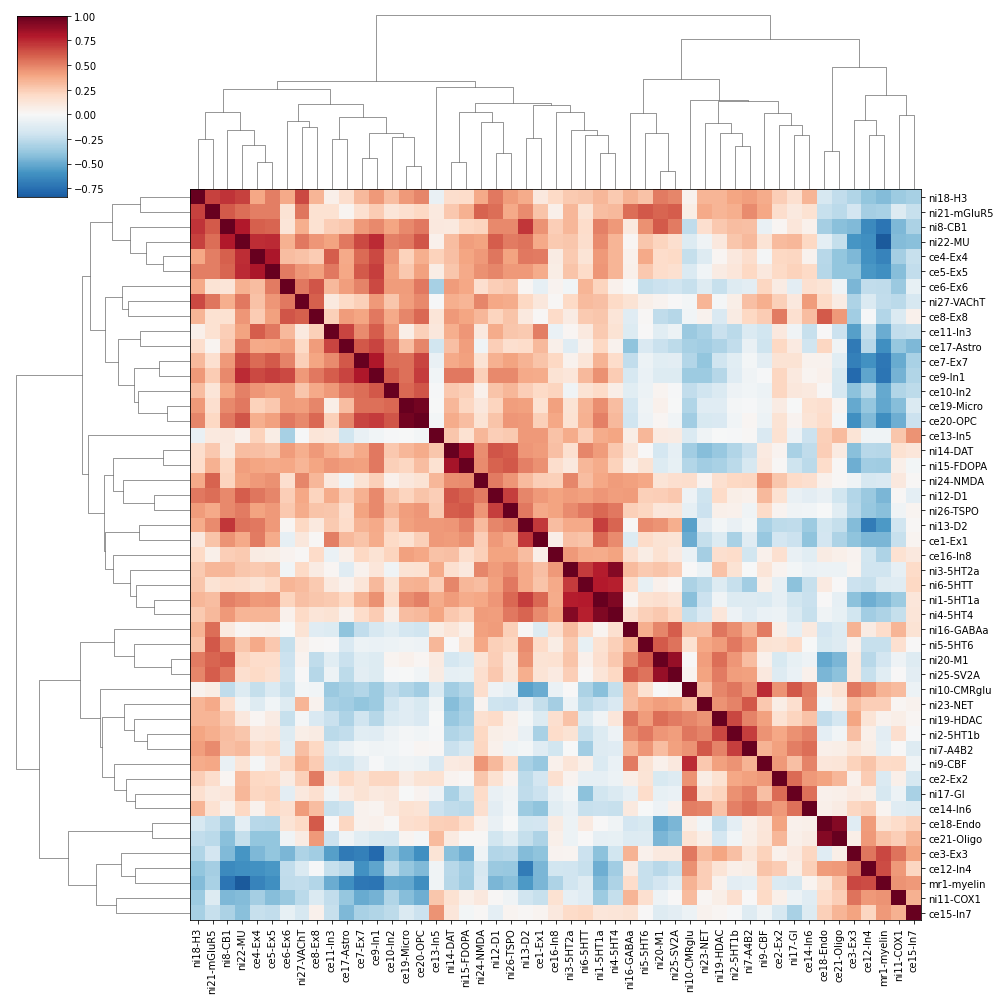

In [35]:
# predictor intercorrelation
sns.clustermap(
    data_parc_destrieux.corr("spearman"),
    center=0, 
    cmap="RdBu_r", 
    figsize=(14,14)
)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig(join(plot_dir, "predictor_correlation_destrieux.pdf"),  bbox_inches="tight")

### Brainplots

Context leak detected, msgtracer returned -1
Context leak detected, msgtracer returned -1


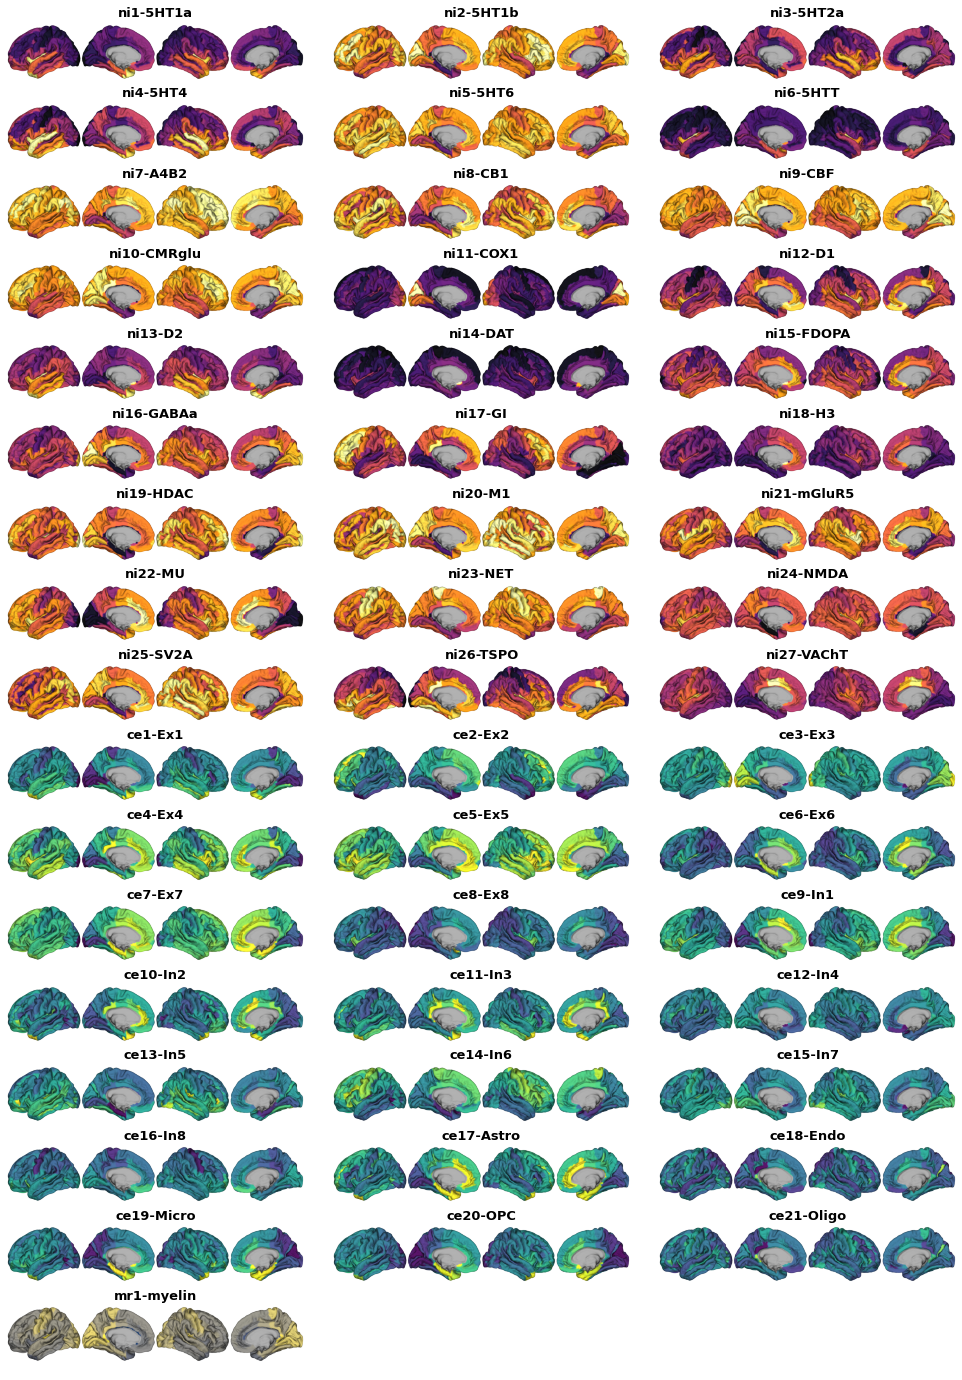

In [36]:
n_cols = 3
n_rows = int(np.ceil(len(data_parc_destrieux.columns)/n_cols)) 
fig, axes = plt.subplots(n_rows,n_cols, figsize=(17,25),
                         gridspec_kw=dict(hspace=0.05, wspace=0.1))
axes = axes.ravel()
for p, ax in zip(data_parc_destrieux, axes):
    lh, rh = get_parc_gifti(data_parc_destrieux[p])
    if p.startswith("ni"): c = "inferno"
    elif p.startswith("ce"): c = "viridis"
    else: c = "cividis"
    plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c=c)
    ax.set_title(p, weight="semibold", size=13)
[ax.axis("off") for ax in axes[len(data_parc_destrieux.columns):]]
    
fig.savefig(join(plot_dir, "predictor_brains.png"), dpi=200, bbox_inches="tight")

### Overview plot

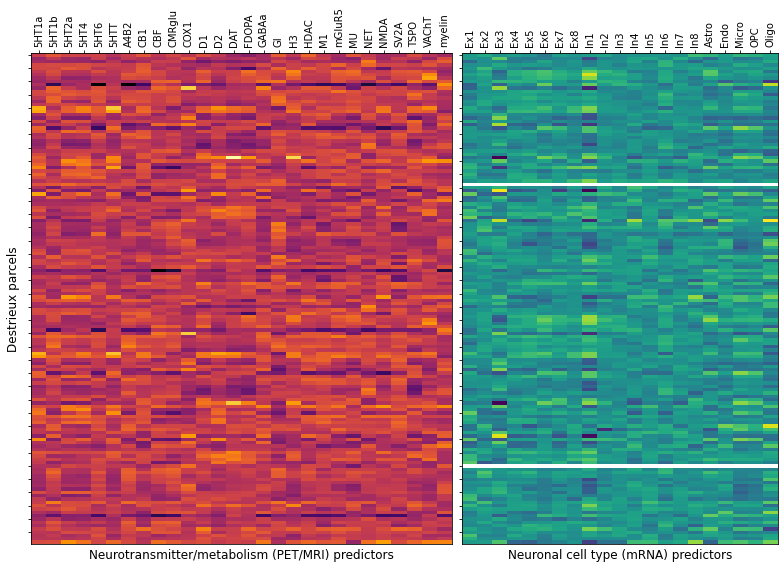

In [37]:
fig, axes = plt.subplots(1,2, figsize=(11,8), sharey=True, 
                         gridspec_kw=dict(width_ratios=(n_ni+1, n_cell)))

sns.heatmap(
    data=pd.concat(
        [pd.read_csv(join(predictor_dir, "ni_parc_destrieux.csv"), index_col=0), 
         pd.read_csv(join(predictor_dir, "mri_parc_destrieux.csv"), index_col=0).\
             rename(columns={"mr1-myelin":"myelin"})], 
        axis=1
    ).iloc[:,:], 
    cbar=None, 
    ax=axes[0], 
    cmap="inferno"
)
axes[0].set_xticklabels(l.get_text().split("_")[0] for l in axes[0].get_xticklabels())
axes[0].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[0].set_ylabel("Destrieux parcels", size=12)
axes[0].set_xlabel("Neurotransmitter/metabolism (PET/MRI) predictors", size=12)

sns.heatmap(
    data=pd.read_csv(join(predictor_dir, "cell_parc_destrieux.csv"), index_col=0).iloc[:,:], 
    cbar=None, 
    ax=axes[1], 
    cmap="viridis"
)
_ = axes[1].set_yticklabels("")
axes[1].set_xticklabels(l.get_text().split("_")[0] for l in axes[1].get_xticklabels())
axes[1].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[1].set_xlabel("Neuronal cell type (mRNA) predictors", size=12)
fig.tight_layout()
sns.despine(top=False, right=False, left=False, bottom=False)

fig.savefig(join(plot_dir, "predictor_overview.pdf"), bbox_inches="tight")

## Dimensionality reduction based on factor analysis

In [38]:
# settings:
fa_method = "minres" # minimum residuals FA
rotation = "promax" # oblique rotation, factors should be allowed to correlate with each other
n_factor_select = "factor_ev" # select factor number based on total or factor-wise EV
n_factor_thresh = 0.01 # retain factors that explain > 1% of variance
factor_label_thresh = 0.3

### PET data

n = 10 factors with ev >= 1.0%


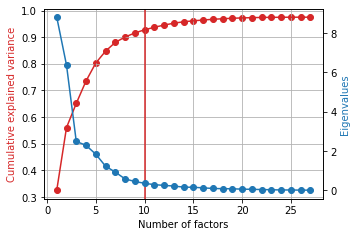

,ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC,ni2-5HT2a-5HT4-5HT1a-5HTT,ni3-FDOPA-DAT-D1-NMDA,ni4-GI-5HT1b-MU-A4B2,ni5-VAChT-NET,ni6-CBF-CMRglu,ni7-COX1,ni8-H3,ni9-D2,ni10-TSPO
eigenvalues,5.354676,4.020665,4.019465,2.814070,1.871108,1.798285,1.775084,1.201746,1.069707,0.621969
prop_variance,0.198321,0.148914,0.148869,0.104225,0.069300,0.066603,0.065744,0.044509,0.039619,0.023036
cum_variance,0.198321,0.347235,0.496104,0.600329,0.669629,0.736232,0.801976,0.846485,0.886104,0.909140


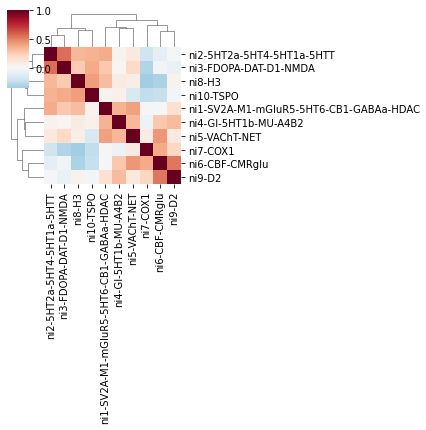

In [39]:
## Find factor number
fa = FactorAnalyzer(n_factors=n_ni, method=fa_method, rotation=None, svd_method="lapack")
fa.fit(ni_parc_destrieux)
# get eigenvalues & explained variance
eig,_ = fa.get_eigenvalues()
ev = fa.get_factor_variance()[2]
ev_frac = fa.get_factor_variance()[1]
comm = fa.get_communalities()

# select n_factors based on overall explained variance
if n_factor_select=="total_ev":
    n_factors = [i for i in range(len(ev)) if (ev[i] >= n_factor_thresh)][1]
    print(f"n = {n_factors} factors explain >= {n_factor_thresh*100}% of variance")
# select n_factors based on factor-level explained variance
elif n_factor_select=="factor_ev":
    n_factors = [i+1 for i in range(len(ev_frac)) if (ev_frac[i] >= n_factor_thresh)][-1]
    print(f"n = {n_factors} factors with ev >= {n_factor_thresh*100}%")

# make scree plot
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(range(1, n_ni+1), ev, c="tab:red")
ax.scatter(range(1, n_ni+1), ev, c="tab:red")
ax2 = ax.twinx()
ax2.plot(range(1, n_ni+1), eig, c="tab:blue")
ax2.scatter(range(1, n_ni+1), eig, c="tab:blue")
ax.set_xlabel('Number of factors')
ax.set_ylabel('Cumulative explained variance', c="tab:red")
ax2.set_ylabel('Eigenvalues', c="tab:blue")
ax.axvline(n_factors, c="tab:red")
ax.grid()
plt.show()
plt.close()

## Run actual factor analysis
fa = FactorAnalyzer(n_factors=n_factors, method=fa_method, rotation=rotation, svd_method="lapack")
fa.fit(ni_parc_destrieux)
# get loadings and derive factor names
loadings = pd.DataFrame(fa.loadings_[:,:n_factors], index=ni_parc_destrieux.columns)
labels = dict()
pred_factor_idx = np.array([loadings.abs().loc[p,:].idxmax() for p in ni_parc_destrieux.columns])
pred_factor_val = np.array([loadings.abs().loc[p,:].max() for p in ni_parc_destrieux.columns])
labels = list()
nt_reordered = list()
for i in range(n_factors):
   labs = pd.Series(data=pred_factor_val[pred_factor_idx==i],
                    index=loadings.index[pred_factor_idx==i]).sort_values(ascending=False)
   nt_reordered += list(labs.index)
   labels.append(f"ni{i+1}-" + "-".join(labs.index))
loadings.columns = labels
# get factor scores
scores_destrieux = pd.DataFrame(
    fa.transform(ni_parc_destrieux)[:,:n_factors], 
    index=ni_parc_destrieux.index, 
    columns=labels)
# get explained variance
variance = pd.DataFrame(
    fa.get_factor_variance(), 
    index=["eigenvalues", "prop_variance", "cum_variance"], 
    columns=labels)
display(variance)

## save
fig.savefig(join(plot_dir, "dimred_ni_scree_destrieux.pdf"), bbox_inches="tight")
scores_destrieux.to_csv(join(predictor_dir, "ni_factors_destrieux.csv"))
loadings.to_csv(join(predictor_dir, "ni_factorloadings_destrieux.csv"))
variance.to_csv(join(predictor_dir, "ni_factorvariance_destrieux.csv"))

# check predictor intercorrelation
sns.clustermap(scores_destrieux.corr("spearman"), center=0, cmap="RdBu_r", figsize=(6,6))

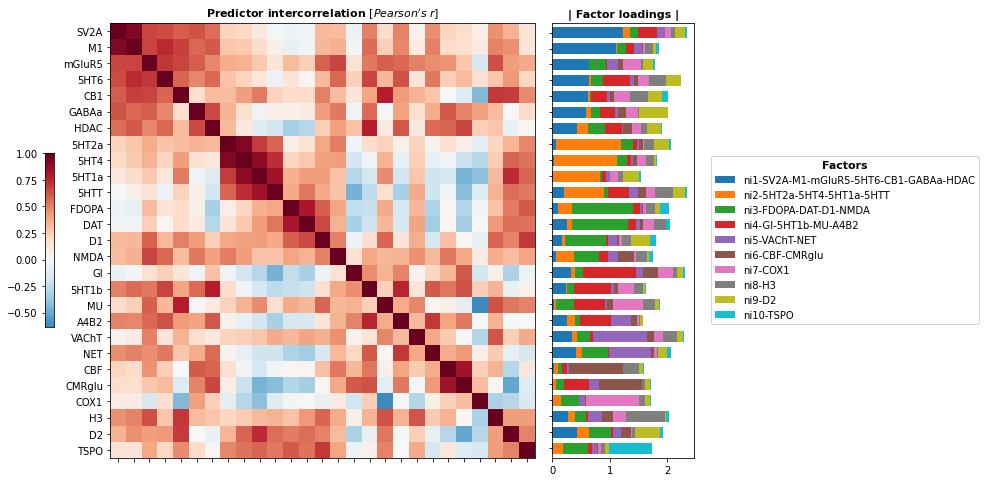

In [40]:
## Plot result

# figure
fig, axes = plt.subplots(1,2, figsize=(13,8), gridspec_kw=dict(width_ratios=(1,0.25), wspace=0.05))
# ax1: heatmap
sns.heatmap(
    ni_parc_destrieux[nt_reordered].corr(method="pearson"), 
    ax=axes[0], 
    center=0, 
    cmap="RdBu_r",
    cbar_kws=dict(location="left", pad=0.1, shrink=0.4))
axes[0].set_xticklabels("")
axes[0].set_title("Predictor intercorrelation $[Pearson's\ r]$", fontsize=11, fontweight="semibold")
# ax2: clustermap
ax = loadings.loc[nt_reordered[::-1],:].abs().plot(
    kind="barh", 
    stacked=True, 
    ax=axes[1],
    edgecolor=None,
    width=.7
    )
axes[1].set_yticklabels("")
axes[1].set_title("| Factor loadings |", fontsize=11, fontweight="semibold")
axes[1].legend(loc="center right", bbox_to_anchor=(3.05,0.5))\
    .set_title("Factors", prop=dict(size=11, weight="semibold"))
sns.despine(top=False, right=False, left=False, bottom=False)

# save
fig.savefig(join(plot_dir, "dimred_ni_loadings_destrieux.pdf"), bbox_inches="tight")

### Cell types

n = 10 factors with ev >= 1.0%


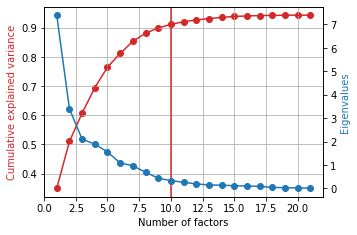

,ce1-Ex7-In4-Ex5-Ex4-In1,ce2-Oligo-Endo,ce3-Micro-OPC,ce4-In3-In2-Astro,ce5-In6-Ex2,ce6-Ex8-Ex6,ce7-In7-Ex3,ce8-In5,ce9-In8,ce10-Ex1
eigenvalues,3.268681,2.549259,2.517569,1.809356,1.782088,1.714052,1.357707,1.149069,1.069272,1.038342
prop_variance,0.155651,0.121393,0.119884,0.086160,0.084861,0.081622,0.064653,0.054718,0.050918,0.049445
cum_variance,0.155651,0.277045,0.396929,0.483089,0.567950,0.649572,0.714224,0.768942,0.819860,0.869304


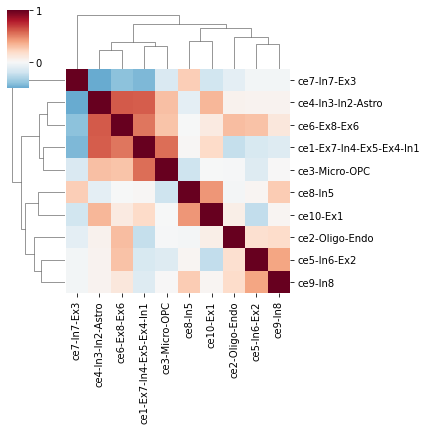

In [41]:
# drop NAs
cell_nan = list(cell_parc_destrieux[cell_parc_destrieux.isna().any(axis=1)].index)
cell_parc_destrieux_nan = cell_parc_destrieux.drop(cell_nan, axis=0)

## Find factor number
fa = FactorAnalyzer(n_factors=n_cell, method=fa_method, rotation=None)
fa.fit(cell_parc_destrieux_nan)
# get eigenvalues & explained variance
eig,_ = fa.get_eigenvalues()
ev = fa.get_factor_variance()[2]
ev_frac = fa.get_factor_variance()[1]

# select n_factors based on overall explained variance
if n_factor_select=="total_ev":
    n_factors = [i for i in range(len(ev)) if (ev[i] > n_factor_thresh)][1]
    print(f"n = {n_factors} factors explain >= {n_factor_thresh*100}% of variance")
# select n_factors based on factor-level explained variance
elif n_factor_select=="factor_ev":
    n_factors = [i+1 for i in range(len(ev_frac)) if (ev_frac[i] > n_factor_thresh)][-1]
    print(f"n = {n_factors} factors with ev >= {n_factor_thresh*100}%")

# make scree plot
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(range(1, n_cell+1), ev, c="tab:red")
ax.scatter(range(1, n_cell+1), ev, c="tab:red")
ax2 = ax.twinx()
ax2.plot(range(1, n_cell+1), eig, c="tab:blue")
ax2.scatter(range(1, n_cell+1), eig, c="tab:blue")
ax.set_xlabel('Number of factors')
ax.set_ylabel('Cumulative explained variance', c="tab:red")
ax2.set_ylabel('Eigenvalues', c="tab:blue")
ax.axvline(n_factors, c="tab:red")
ax.grid()
plt.show()
plt.close()

## Run actual factor analysis
fa = FactorAnalyzer(n_factors=n_factors, method=fa_method, rotation=rotation, impute="drop")
fa.fit(cell_parc_destrieux_nan)
# get loadings and derive factor names
loadings = pd.DataFrame(fa.loadings_, index=cell_parc_destrieux.columns)
pred_factor_idx = np.array([loadings.abs().loc[p,:].idxmax() for p in cell_parc_destrieux.columns])
pred_factor_val = np.array([loadings.abs().loc[p,:].max() for p in cell_parc_destrieux.columns])
labels = list()
nt_reordered = list()
for i in range(n_factors):
    labs = pd.Series(data=pred_factor_val[pred_factor_idx==i],
                     index=loadings.index[pred_factor_idx==i]).sort_values(ascending=False)
    nt_reordered += list(labs.index)
    labels.append(f"ce{i+1}-" + "-".join(labs.index))
loadings.columns = labels
# get factor scores
scores_destrieux = fa.transform(cell_parc_destrieux_nan)
scores_destrieux = fill_nan(
    data=pd.DataFrame(scores_destrieux, index=cell_parc_destrieux_nan.index, columns=labels),
    idx=[list(cell_parc_destrieux.index).index(i) for i in cell_nan],
    idx_label=cell_nan,
    which="row")
# get explained variance
variance = pd.DataFrame(
    fa.get_factor_variance(), 
    index=["eigenvalues", "prop_variance", "cum_variance"], 
    columns=labels)
display(variance)

## save
fig.savefig(join(plot_dir, "dimred_cell_scree_destrieux.pdf"), bbox_inches="tight")
scores_destrieux.to_csv(join(predictor_dir, "cell_factors_destrieux.csv"))
loadings.to_csv(join(predictor_dir, "cell_factorloadings_destrieux.csv"))
variance.to_csv(join(predictor_dir, "cell_factorvariance_destrieux.csv"))

# check predictor intercorrelation
sns.clustermap(scores_destrieux.corr("spearman"), center=0, cmap="RdBu_r", figsize=(6,6))

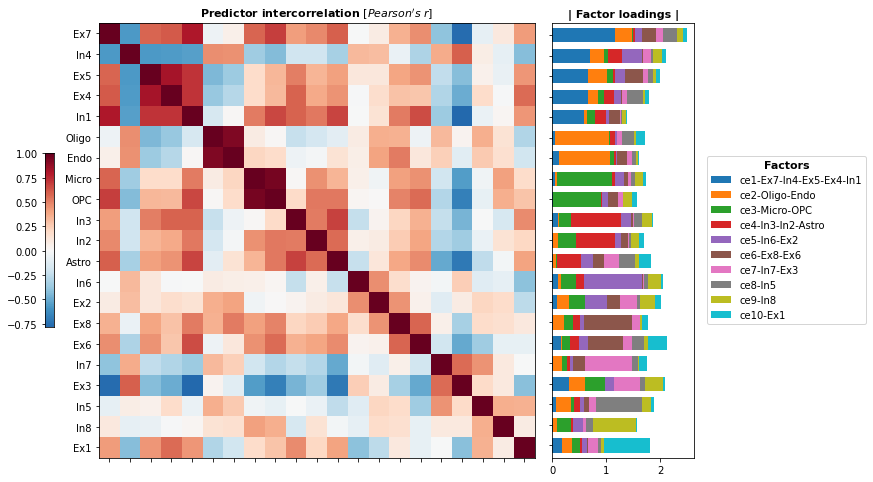

In [42]:
## Plot result

# figure
fig, axes = plt.subplots(1,2, figsize=(13,8), gridspec_kw=dict(width_ratios=(1,0.25), wspace=0.05))
# ax1: heatmap
sns.heatmap(
    cell_parc_destrieux[nt_reordered].corr(method="pearson"), 
    ax=axes[0], 
    center=0, 
    cmap="RdBu_r",
    cbar_kws=dict(location="left", pad=0.08, shrink=0.4))
axes[0].set_xticklabels("")
axes[0].set_title("Predictor intercorrelation $[Pearson's\ r]$", fontsize=11, fontweight="semibold")
# ax2: clustermap
loadings.loc[nt_reordered[::-1],:].abs().plot(
    kind="barh", 
    stacked=True, 
    ax=axes[1],
    edgecolor=None,
    width=.7
    )
axes[1].set_yticklabels("")
axes[1].set_title("| Factor loadings |", fontsize=11, fontweight="semibold")
axes[1].legend(loc="center right", bbox_to_anchor=(2.25,0.5))\
    .set_title("Factors", prop=dict(size=11, weight="semibold"))
sns.despine(top=False, right=False, left=False, bottom=False)

# save
fig.savefig(join(plot_dir, "dimred_cell_loadings_destrieux.pdf"), bbox_inches="tight")

## Collect predictors

In [43]:
data_scores_destrieux = pd.concat(
    [pd.read_csv(join(predictor_dir, "ni_factors_destrieux.csv"), index_col=0),
     pd.read_csv(join(predictor_dir, "cell_factors_destrieux.csv"), index_col=0),
     pd.read_csv(join(predictor_dir, "mri_parc_destrieux.csv"), index_col=0)],
    axis=1)
data_scores_destrieux.to_csv(join(predictor_dir, "data_factors_destrieux.csv"))
data_scores_destrieux.shape 

(148, 21)

### Intercorrelation

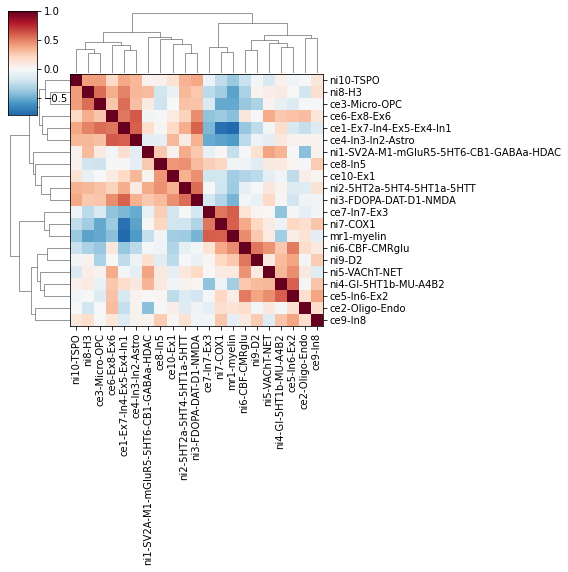

In [44]:
# predictor intercorrelation ni + cell
sns.clustermap(data_scores_destrieux.corr("spearman"),
               center=0, 
               cmap="RdBu_r", 
               figsize=(8,8))
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig(join(plot_dir, f'dimred_factor_correlation_destrieux.pdf'),  bbox_inches='tight')

### Brainplots

Context leak detected, msgtracer returned -1


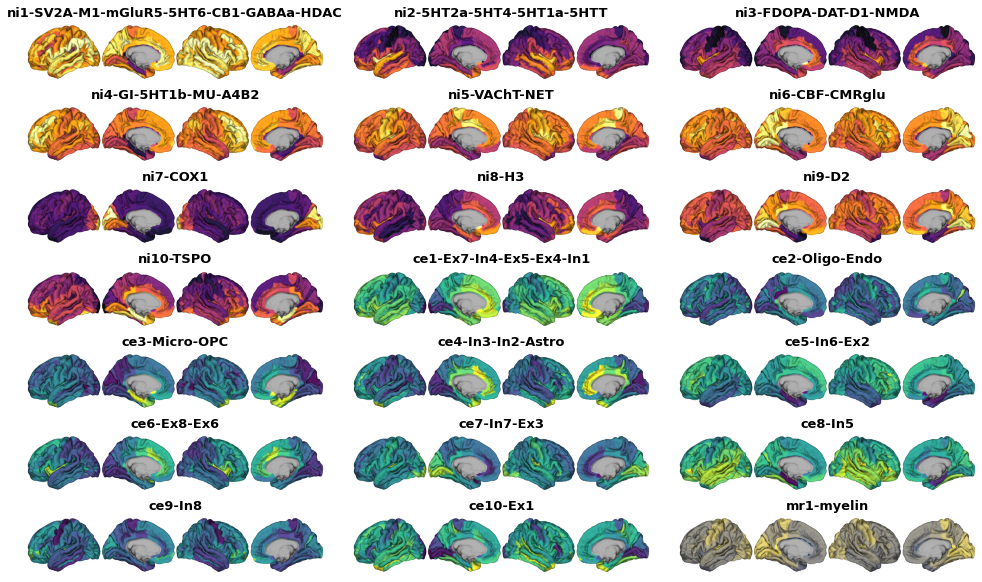

In [45]:
n_cols = 3
n_rows = int(np.ceil(len(data_scores_destrieux.columns)/n_cols)) 
fig, axes = plt.subplots(n_rows,n_cols, figsize=(17,10.5),
                         gridspec_kw=dict(hspace=0.05, wspace=0.1))
axes = axes.ravel()
for p, ax in zip(data_scores_destrieux, axes):
    lh, rh = get_parc_gifti(data_scores_destrieux[p])
    if p.startswith("ni"): c = "inferno"
    elif p.startswith("ce"): c = "viridis"
    else: c = "cividis"
    plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c=c)
    ax.set_title(p, weight="semibold", size=13)
[ax.axis("off") for ax in axes[len(data_scores_destrieux.columns):]]
    
fig.savefig(join(plot_dir, "dimred_predictor_brains.png"), dpi=200, bbox_inches="tight")

### Overview plot

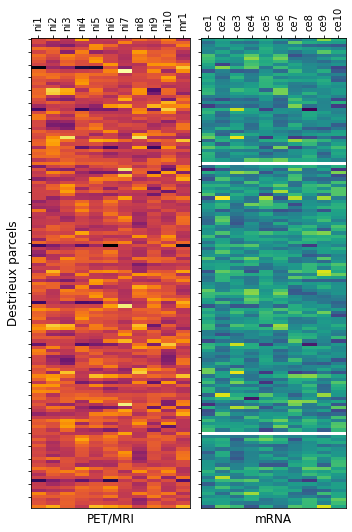

In [46]:
fig, axes = plt.subplots(1,2, figsize=(5,7.5), sharey=True, 
                         gridspec_kw=dict(width_ratios=(
                             len([c for c in data_scores_destrieux.columns if not c.startswith("ce")]), 
                             len([c for c in data_scores_destrieux.columns if c.startswith("ce")]))))

sns.heatmap(
    data=data_scores_destrieux[[c for c in data_scores_destrieux.columns if not c.startswith("ce")]], 
    cbar=None, 
    ax=axes[0], 
    cmap="inferno"
)
axes[0].set_xticklabels(l.get_text().split("-")[0] for l in axes[0].get_xticklabels())
axes[0].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[0].set_ylabel("Destrieux parcels", size=12)
axes[0].set_xlabel("PET/MRI", size=12)

sns.heatmap(
    data=data_scores_destrieux[[c for c in data_scores_destrieux.columns if c.startswith("ce")]], 
    cbar=None, 
    ax=axes[1], 
    cmap="viridis"
)
_ = axes[1].set_yticklabels("")
axes[1].set_xticklabels(l.get_text().split("-")[0] for l in axes[1].get_xticklabels())
axes[1].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[1].set_xlabel("mRNA", size=12)
fig.tight_layout()
sns.despine(top=False, right=False, left=False, bottom=False)

fig.savefig(join(plot_dir, "dimred_predictor_overview.pdf"), bbox_inches="tight")